# Part 1

In [1]:
# Libraries, options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_colwidth', 16)
pd.set_option("display.precision", 3)

# Digital Payment Data

In [2]:
# Import data
data = pd.read_excel("Digital Planet_Candidate Assessment Part I.xlsx",
                    sheet_name = "Made Digital Payments",
                    header = 2)

In [3]:
# Get rid of empty first column
data = data.iloc[:, 1:]

In [4]:
# Rename columns
data.columns = ["country", "region", "income", "dpay", "year"]

In [5]:
# Set data to wide format
data = data.pivot(index=["country", "region", "income"],
                  columns="year", values="dpay").add_prefix("dpay_").reset_index()
data = data.rename_axis(None, axis=1)

In [6]:
# Take a peek at the data
data.head()

,country,region,income,dpay_2014,dpay_2017,dpay_2019
0,Argentina,Latin Americ...,Upper middle...,0.313,0.319,NaN
1,Australia,High income,High income,0.932,0.936,NaN
2,Brazil,Latin Americ...,Upper middle...,0.470,0.459,NaN
3,Canada,High income,High income,0.949,0.970,NaN
4,Chile,High income,High income,0.470,0.564,NaN


# Imputing 2014/2017 Values
- Because the countries with missing 2014/2017 values only have one observation, we have fewer options for this imputation
- One possibility is that we could look at countries with similar regions/income and use the average of those values
- Another possibility is that we could just set the missing 2014/2017 values equal to their other dpay value (no country is missing all three)

Because I suspect that within-country variation will have a higher impact than the region/income categories, I'm going to replace the missing 2014/2017 value with the country's available 2014/2017 value.

In [7]:
# Which countries have missing 2014 values?
data[data["dpay_2014"].isnull()]

,country,region,income,dpay_2014,dpay_2017,dpay_2019
6,Colombia,Latin Americ...,Upper middle...,NaN,0.285,NaN
22,Philippines,East Asia & ...,Lower middle...,NaN,0.136,NaN


In [8]:
# Set these values equal to their 2017 values
data.loc[6, "dpay_2014"] = data.loc[6, "dpay_2017"]
data.loc[22, "dpay_2014"] = data.loc[22, "dpay_2017"]

In [9]:
# Which countries have missing 2017 values?
data[data["dpay_2017"].isnull()]

,country,region,income,dpay_2014,dpay_2017,dpay_2019
12,Ireland,High income,High income,0.846,NaN,NaN
18,Mexico,Latin Americ...,Upper middle...,0.253,NaN,NaN


In [10]:
# Set these values equal to their 2014 values
data.loc[12, "dpay_2017"] = data.loc[12, "dpay_2014"]
data.loc[18, "dpay_2017"] = data.loc[18, "dpay_2014"]

# Imputing 2019 Values
Here are the main imputation options I considered for this data:
- Set 2019 equal to 2017 (most recent observation)
- Set 2019 equal to the average of 2017 and 2014 (taking mean seems reasonable)
- Project trend from 2014 to 2017 up to 2019 (constant trends assumption)
- Use average from region/income level to impute data

Of these options, using 2017 only doesn't make sense because we have access to more data. Taking the mean of 2014 and 2017 seems reasonable, but this wouldn't account for the upward/downward trajectory of the data. Using averages from the same region/income level also seems fine, but I suspect that within-country variation explains much more about the usage of digital payments than the broad characteristics of the country. Therefore, I'm going to impute the 2019 values by projecting the trend from 2014 to 2017. Note that this will create some values greater than 1, so I'm going to add half of the change from 2014 to 2017. I could have just capped the values at 1, but this would have led to a bunch of 1 values.

In [11]:
# Impute 2019 values of dpay by continuing trend from 2014-2017
data["dpay_2019"] = data["dpay_2017"] + 0.5 * (data["dpay_2017"] - data["dpay_2014"])

# Trust in Tech Industry Data

In [12]:
# Import Data
data1 = pd.read_excel("Digital Planet_Candidate Assessment Part I.xlsx",
                      sheet_name = "Trust in Tech Industry",
                      header = 2)

In [13]:
# Get rid of empty first column
data1 = data1.iloc[:, 1:]

In [14]:
# Rename columns, get rid of year
data1.columns = ["country", "ptrust_2017", "year"]
data1 = data1.iloc[:, :2]

In [15]:
# Take a peek at the data
data1.head()

,country,ptrust_2017
0,Argentina,77.0
1,Australia,71.0
2,Brazil,82.0
3,Canada,72.0
4,Chile,NaN


In [16]:
# I want to merge the datasets, but they use different country names
# Names used in the first dataset
x = data.country.unique()
y = data1.country.unique()
np.setdiff1d(x, y)

array(['Hong Kong SAR, China', 'Korea, Rep.', 'Philippines',
       'Russian Federation', 'United Arab Emirates', 'United Kingdom',
       'United States'], dtype=object)

In [17]:
# Names used in the second dataset
np.setdiff1d(y, x)

array(['Hong Kong', 'Phillipines', 'Russia', 'South Korea', 'UAE', 'UK',
       'US'], dtype=object)

In [18]:
# Replace country names with counterparts from first dataset
data1.iloc[9, 0] = 'Hong Kong SAR, China'
data1.iloc[21, 0] = 'Philippines'
data1.iloc[23, 0] = 'Russian Federation'
data1.iloc[26, 0] = 'Korea, Rep.'
data1.iloc[30, 0] = 'United Arab Emirates'
data1.iloc[31, 0] = 'United Kingdom'
data1.iloc[32, 0] = 'United States'

In [19]:
# Merge datasets
data = data.merge(data1, how = "inner", on = "country")

In [20]:
# Make sure everything went okay
data.head()

,country,region,income,dpay_2014,dpay_2017,dpay_2019,ptrust_2017
0,Argentina,Latin Americ...,Upper middle...,0.313,0.319,0.322,77.0
1,Australia,High income,High income,0.932,0.936,0.938,71.0
2,Brazil,Latin Americ...,Upper middle...,0.470,0.459,0.454,82.0
3,Canada,High income,High income,0.949,0.970,0.981,72.0
4,Chile,High income,High income,0.470,0.564,0.611,NaN


# Imputing Ptrust Values
- Once again, we have limited options for imputing this data
- Because there's only one year for the ptrust variable, we can't infer values from previous years
- This means that we can only really infer values from countries with similar regions/income levels

Because of this, I'm going to be inferring ptrust values from countries with similar regions/incomes. For the high income region/income countries, there's a reasonable amount of countries, so I'm going to take the mean ptrust value from countries that have region and income both equal to high income. For the other countries, I'm just going to take the mean ptrust value from countries in the same region because there are fewer observations.

In [21]:
# Which countries have missing ptrust values?
data[data["ptrust_2017"].isnull()]

,country,region,income,dpay_2014,dpay_2017,dpay_2019,ptrust_2017
4,Chile,High income,High income,0.470,0.564,0.611,NaN
9,Hong Kong SA...,High income,High income,0.761,0.774,0.781,NaN
15,Kenya,Sub-Saharan ...,Lower middle...,0.662,0.764,0.815,NaN
20,Nigeria,Sub-Saharan ...,Lower middle...,0.292,0.237,0.210,NaN
21,Norway,High income,High income,0.978,0.989,0.994,NaN
22,Philippines,East Asia & ...,Lower middle...,0.136,0.136,0.136,NaN
28,Sweden,High income,High income,0.977,0.975,0.974,NaN
31,United Kingdom,High income,High income,0.956,0.942,0.934,NaN


In [22]:
# Replace values for countries with high income
high_ptrust = data[(data.region=="High income") & (data.income=="High income")]["ptrust_2017"].mean()
data.loc[[4,9,21,28,31], "ptrust_2017"] = high_ptrust

In [23]:
# Replace values for African countries
africa_ptrust = data[data.region=="Sub-Saharan Africa (excluding high income)"]["ptrust_2017"].mean()
data.loc[[15,20], "ptrust_2017"] = africa_ptrust

In [24]:
# Replace value for the Philippines
sea_ptrust = data[data.region=="East Asia & Pacific (excluding high income)"]["ptrust_2017"].mean()
data.loc[22, "ptrust_2017"] = sea_ptrust

In [25]:
# How does the final dataframe look?
data.head()

,country,region,income,dpay_2014,dpay_2017,dpay_2019,ptrust_2017
0,Argentina,Latin Americ...,Upper middle...,0.313,0.319,0.322,77.000
1,Australia,High income,High income,0.932,0.936,0.938,71.000
2,Brazil,Latin Americ...,Upper middle...,0.470,0.459,0.454,82.000
3,Canada,High income,High income,0.949,0.970,0.981,72.000
4,Chile,High income,High income,0.470,0.564,0.611,71.643


In [26]:
# Save to csv
data.to_csv("part_1.csv")

# Visualization

In [27]:
# What income groups are there?
data.income.value_counts()

High income            19
Upper middle income     9
Lower middle income     5
Name: income, dtype: int64

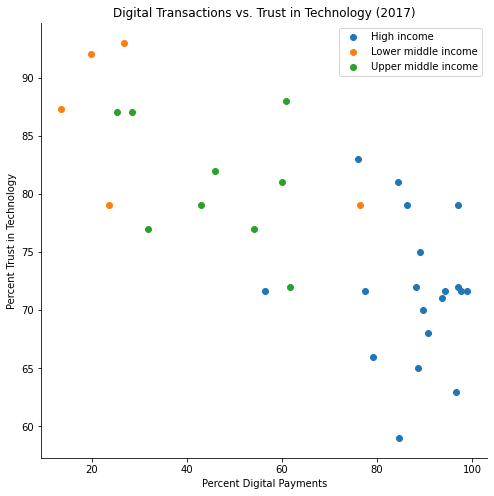

In [28]:
# Scatter dpay vs. ptrust by income group
fig, ax = plt.subplots(figsize=(8,8))
groups = data.groupby("income")
for name, group in groups:
    plt.scatter(100 * group["dpay_2017"], group["ptrust_2017"], label=name)
    
ax.set_title("Digital Transactions vs. Trust in Technology (2017)")
ax.set_xlabel("Percent Digital Payments")
ax.set_ylabel("Percent Trust in Technology")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.legend();

- For this graphic, I made a scatter plot of the percentage trust in technology vs percentage who made digital payments by country (both from 2017)
    - I also considered graphing the change in percent digital payments, but there wasn't as clear of a pattern
- Additionally, I colored each datapoint by the income level of the country
- Note that the x and y axes start at 20 and 60 percent, respectively
- For the most part, each income group forms a nice cluster of datapoints
    - High income countries tend to made many digital payments and have low trust in tech
    - Upper middle income countries made a medium amount of digital payments and have medium trust in tech
    - Lower middle income countries made relatively few digital payments but have high trust in tech (only Kenya made many payments)

# What can we learn from these datasets?

In [29]:
# Correlations
data.corr()

,dpay_2014,dpay_2017,dpay_2019,ptrust_2017
dpay_2014,1.000,0.958,0.906,-0.704
dpay_2017,0.958,1.000,0.990,-0.711
dpay_2019,0.906,0.990,1.000,-0.693
ptrust_2017,-0.704,-0.711,-0.693,1.000


In [30]:
# Some summary statistics
data.describe().transpose()[["mean", "min", "max", "std"]]

,mean,min,max,std
dpay_2014,0.630,0.136,0.978,0.282
dpay_2017,0.678,0.136,0.989,0.276
dpay_2019,0.702,0.136,0.994,0.282
ptrust_2017,76.411,59.000,93.000,8.261


In [31]:
# Average value by group
x = data.groupby("income").mean().transpose()
x[["Lower middle income", "Upper middle income", "High income"]]

income,Lower middle income,Upper middle income,High income
dpay_2014,0.282,0.397,0.833
dpay_2017,0.321,0.457,0.876
dpay_2019,0.340,0.487,0.898
ptrust_2017,86.067,81.111,71.643


- There seems to be a negative correlation between trust in the tech industry and the percentage of people who made digital payments
- People from lower middle income countries have a high amount of trust in tech, but they make relatively few digital payments
- The amount of people making digital payments has been steadily increasing
- Because of this, it seems like policies promoting the usage of digital payments in poorer countries have a good likelihood of succeeding
- However, there are a bunch of limitations and caveats that accompany this idea
    - The bottleneck for making digital payments clearly isn't trust, so factors like education, knowledge of personal finance, access to technology, availability of services, etc. might be the main things preventing usage of e-commerce, and these could be hard to change
    - This dataset doesn't have information on many countries, so there might be a completely different story elsewhere
- Therefore, it would be interesting to follow up on this analysis and ask a bunch of new questions:
    - Do these trends persist in poorer countries not represented in this data?
    - What is the main thing that prevents people in poorer countries from accessing the digital economy?
    - Do people in poorer countries want to use technology for the digital economy, or for other reasons?
    - Do people in poorer countries have the knowledge to use the digital economy?
    - How many countries provide digital services for people in poorer countries?